# In this analysis, we are taking a set of peaks and finding those peaks that contain a motif

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import glob
import pybedtools
import pysam
import re
import urllib
import sqlite3
import random
from random import sample 
from collections import Counter
from tqdm import tnrange, tqdm_notebook
from xml.dom import minidom
from Bio import SeqIO
from matplotlib_venn import venn2
pd.set_option('display.max_colwidth', 1000)

In [2]:
input_dir = '/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_bulk_rnaseq/inputs/'
output_dir = '/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_bulk_rnaseq/outputs/'

In [3]:
slop = 0  # leave at 0 since we're starting with the full 3'utr region.
motif = 'TTTTC'

# Define our peak sites
- These may come from multiple sources. I'm trying to classify them according to how they were annotated (if they were annotated). 

In [4]:
hist_genes = '/home/rmarina/projects/apobec/ref_files/histone_genes.bed'
regions_of_interest = '/projects/ps-yeolab3/bay001/annotations/hg19/gencode_v19/hg19_v19_cds_and_three_prime_utrs.bed'

assert os.path.exists(hist_genes)

### Read in hist genes and intersect geneids with our regions of interest to get the CDS and 3'UTRs for these genes only.

In [5]:
all_genes = pd.read_csv(hist_genes, sep='\t', names=['chrom','start','end','geneid','genename','strand'])[['geneid','genename']]
print("Number of histone genes: (should be 122 but in case Ryan updates this file) {}".format(all_genes.shape[0]))
all_regions = pd.read_csv(regions_of_interest, sep='\t', names=['chrom','start','end','geneid','score','strand'])

regions = pd.merge(all_genes, all_regions, how='left', left_on=['geneid'], right_on=['geneid'])
print("Number of histone genes that are missing CDS or 3UTR: {}".format(regions.shape[0] - regions.dropna().shape[0]))
regions.dropna(inplace=True)
regions.head()

Number of histone genes: (should be 122 but in case Ryan updates this file) 122
Number of histone genes that are missing CDS or 3UTR: 33


,geneid,genename,chrom,start,end,score,strand
3,ENSG00000203818.6,HIST2H3PS2,chr1,149400134.0,149400542.0,0.0,-
4,ENSG00000203818.6,HIST2H3PS2,chr1,149400130.0,149400134.0,0.0,-
5,ENSG00000203814.5,HIST2H2BF,chr1,149754791.0,149754816.0,0.0,-
6,ENSG00000203814.5,HIST2H2BF,chr1,149765522.0,149765643.0,0.0,-
7,ENSG00000203814.5,HIST2H2BF,chr1,149783500.0,149783878.0,0.0,-


### Re-format these 243 regions (exons) into a BED-like format. 

In [6]:
regions['start'] = regions['start'].astype(int)
regions['end'] = regions['end'].astype(int)
regions = regions[['chrom','start','end','geneid','score','strand']]
print(regions.shape[0])
regions.head()

243


,chrom,start,end,geneid,score,strand
3,chr1,149400134,149400542,ENSG00000203818.6,0.0,-
4,chr1,149400130,149400134,ENSG00000203818.6,0.0,-
5,chr1,149754791,149754816,ENSG00000203814.5,0.0,-
6,chr1,149765522,149765643,ENSG00000203814.5,0.0,-
7,chr1,149783500,149783878,ENSG00000203814.5,0.0,-


### For this dataset, we already know that these cover 3'UTRs and CDS regions.

# get the fasta sequences and check for existence of motif

## Convert our filtered peaks to BedTool objects.

In [7]:
genome_fasta = '/projects/ps-yeolab3/bay001/annotations/hg19/hg19.fa'
chrom_sizes = '/projects/ps-yeolab3/bay001/annotations/hg19/hg19.chrom.sizes'

def get_peak_interval_from_annotated_dataframe(df, slop, chrom_sizes=None):
    """ 
    Returns a bedtool from a peaks dataframe. 
    Peaks dataframe is generated from above (regions).
    Merges the bedtool so we reduce chance of overlapping. 
    Merging also "connects" CDS and 3'UTR regions
    """
    
    bedtool = pybedtools.BedTool.from_dataframe(df).sort()
    bedtool = bedtool.slop(b=slop, g=chrom_sizes)
    print("size prior to merge: {}".format(bedtool.to_dataframe().shape[0]))
    bedtool = bedtool.merge(c=(4,5,6), s=True, o=('distinct','collapse','distinct'))
    print("size after merge: {}".format(bedtool.to_dataframe().shape[0]))
    return bedtool

# utr3_bedtool is a bedtool-ified version of the annotated dataframe for JUST 3'UTR peaks.
peaks_bedtool = get_peak_interval_from_annotated_dataframe(regions, slop=slop, chrom_sizes=chrom_sizes)

size prior to merge: 243
size after merge: 142


/home/bay001/anaconda2/envs/python3-essential/lib/python3.6/site-packages/pybedtools/bedtool.py:3439: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pandas.read_table(self.fn, *args, **kwargs)
/home/bay001/anaconda2/envs/python3-essential/lib/python3.6/site-packages/pybedtools/bedtool.py:3439: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pandas.read_table(self.fn, *args, **kwargs)


# Need some kind of set of genes that are considered "bound by SLBP." 
- So we're going to use the original gene list from Ryan and return the genes that have a 3'UTR or CDS (so not Pseudogenes).

{'ENSG00000178458.5',
 'ENSG00000178762.3',
 'ENSG00000181201.2',
 'ENSG00000203819.6',
 'ENSG00000206417.4',
 'ENSG00000213244.3',
 'ENSG00000213440.2',
 'ENSG00000216331.1',
 'ENSG00000216436.2',
 'ENSG00000217646.1',
 'ENSG00000217862.2',
 'ENSG00000218281.1',
 'ENSG00000218502.3',
 'ENSG00000218690.1',
 'ENSG00000220323.3',
 'ENSG00000220875.1',
 'ENSG00000223345.3',
 'ENSG00000223383.1',
 'ENSG00000224447.1',
 'ENSG00000226881.4',
 'ENSG00000226908.1',
 'ENSG00000230618.3',
 'ENSG00000233320.2',
 'ENSG00000233733.1',
 'ENSG00000234289.4',
 'ENSG00000234612.1',
 'ENSG00000235655.2',
 'ENSG00000236534.1',
 'ENSG00000240929.2',
 'ENSG00000242387.1',
 'ENSG00000255329.1',
 'ENSG00000259389.2',
 'ENSG00000265541.1'}

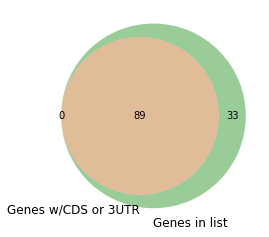

In [8]:
x = peaks_bedtool.to_dataframe()
venn2([set(x['name']), set(all_genes['geneid'])], ['Genes w/CDS or 3UTR', 'Genes in list'])
set(all_genes['geneid']).difference(set(x['name']))

In [9]:
with open(os.path.join(output_dir, 'histone_genes_with_cds_or_3utr_annotations.txt'), 'w') as o:
    for i in set(x['name']):
        o.write("{}\n".format(i))

In [10]:
def record_id_to_coords(id_string):
    """ 
    Turns a seqrecord fasta id into coordinates.
    seqrecord fasta ids (stranded) look like this:
    
    chr11:1774028-1774186(-)
    
    """
    chrom, pos = id_string.split(':')
    coord, strand = pos.split('(')
    strand = strand.replace(')','')
    start, end = coord.split('-')
    try:
        assert (strand == '+') or (strand == '-')
    except AssertionError:
        print("Strand not correct: [{}]".format(strand))
        return 1
    return chrom, int(start), int(end), strand

# Get the sequence from the 3'UTR peaks and save them. This will report strand-specific, so negative stranded coordinates will return the reverse complement. 

In [11]:
def write_peaks_as_fasta(bedtool, genome_fa, output_fasta):
    """
    Writes peaks as strand-specific FASTA sequences. 
    s=True means we will be returning the reverse complement 
    sequence for negative strand peaks.
    """
    seq_bedtool = bedtool.sequence(fi=genome_fa, s=True)
    with open(output_fasta, 'w') as f:
        f.write(open(seq_bedtool.seqfn).read())

output_fasta = os.path.join(output_dir, os.path.splitext(os.path.basename(hist_genes))[0] + ".fasta")

write_peaks_as_fasta(
    bedtool=peaks_bedtool,
    genome_fa=genome_fasta,
    output_fasta=output_fasta
)

In [12]:
def get_positions(record, motif, slop):
    """
    Iterates over a sequence and returns positions that match a motif.
    """
    
    positions = []
    chrom, start, end, strand = record_id_to_coords(record.id)
    i = 0
    
    while i < len(record.seq)-len(motif):
        kmer = record.seq[i:i+len(motif)].upper()
        if kmer == motif:
            if strand == '+':
                positions.append("{}\t{}\t{}\t{}\t{}\t{}\n".format(
                    chrom, i+start-slop, i+start+len(motif)+slop, motif, '0', strand
                ))
            elif strand == '-':
                positions.append("{}\t{}\t{}\t{}\t{}\t{}\n".format(
                    chrom, end-i-len(motif)-slop, end-i+slop, motif, '0', strand
                ))
        i+=1
    return positions


positions = []
records = SeqIO.parse(output_fasta, "fasta")
for record in records:
    positions += get_positions(record, motif, slop=10)

print("Number of \"peaks\" found: {}".format(len(positions)))
with open(os.path.join(output_dir, os.path.splitext(os.path.basename(hist_genes))[0] + ".with.{}.bed".format(motif)), 'w') as o:
    for position in positions:
        o.write(position)

Number of "peaks" found: 199


# Make sure every sequence we have has the motif.

In [13]:
def return_sequence_records_with_motif(fn, motif):
    """
    Returns a SeqIO record of sequences containing the motif. We expect this 
    FASTA file to contain the reverse-complement sequences if negative strand. 
    We also expect the FASTA headers to contain strand info 
    @see BedTool.sequence(fi=hg19.fa, s=True)
    """
    seqs_with_motif = []
    with open(fn, 'r') as f:
        for record in SeqIO.parse(f, "fasta"):
            chrom, start, end, strand = record_id_to_coords(record.id)
            if (strand == '+' or strand =='-') and str(record.seq).upper().find(motif) != -1:
                seqs_with_motif.append(record)
            else:
                assert strand == '+' or strand == '-'
    return seqs_with_motif

seqs_with_motif = return_sequence_records_with_motif(fn=os.path.join(output_dir, os.path.splitext(os.path.basename(hist_genes))[0] + ".with.{}.bed".format(motif)), motif=motif)

# Make sure every region describes a motif

for record in seqs_with_motif:
    try:
        record_upper = record.seq.upper()
        assert record_upper[record_upper.find(motif):record_upper.find(motif)+len(motif)] == motif
    except AssertionError:
        print(record)